In [1]:
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
# const GLenum POINTS                         = 0x0000;
# const GLenum LINES                          = 0x0001;
# const GLenum LINE_LOOP                      = 0x0002;
# const GLenum LINE_STRIP                     = 0x0003;
# const GLenum TRIANGLES                      = 0x0004;
# const GLenum TRIANGLE_STRIP                 = 0x0005;
# const GLenum TRIANGLE_FAN                   = 0x0006;
gl_types = {
    0: "POINTS",
    1: "LINES",
    2: "LINE_LOOP",
    3: "LINE_STRIP",
    4: "TRIANGLES",
    5: "TRIANGLE_STRIP",
    6: "TRIANGLE_FAN",
}

In [3]:
df_frame = pd.read_pickle('imr/0501-df_frame-raf.pkl.zst', compression='zstd')
# df_context = pd.read_pickle('imr/0501-df_context.pkl.zst', compression='zstd')
df_context_noraf = pd.read_pickle('imr/0501-df_context-noraf.pkl.zst', compression='zstd')

In [4]:
df_context_noraf['idx-frame'].value_counts().describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count    18761.000000
mean         3.487394
std         24.079711
min          1.000000
50%          2.000000
75%          3.000000
90%          4.000000
95%          6.000000
99%         12.000000
max        919.000000
Name: count, dtype: float64

In [56]:
df_context_noraf[df_context_noraf['idx-frame']==2119].to_excel('tmp.xlsx')

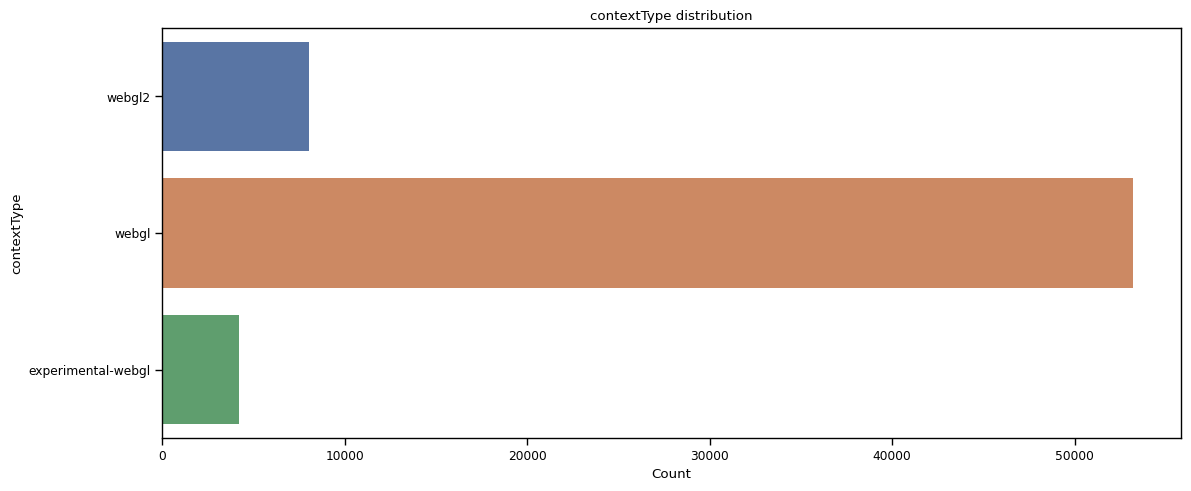

In [6]:
# df_context_noraf["frame.context.maghsk.createArguments.0"].value_counts()
fig, axes = plt.subplots(figsize=(12, 5))
sns.countplot(y="frame.context.maghsk.createArguments.0", data=df_context_noraf, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('contextType')
axes.set_title('contextType distribution')
plt.tight_layout()

In [ ]:
trace_path_list = sorted((raf_path / 'pickle').glob('*.pkl.zstd'))
df_traces = pd.DataFrame([pkl.load(zstd.open(x, 'rb')) for x in trace_path_list], index=[x.name for x in trace_path_list])
# rename index to filename
df_traces.index.name = 'filename'
df_traces.rename(columns={'gl_info': 'gl_info_raf'}, inplace=True)

In [ ]:
df_traces_status = pd.DataFrame(list(df_traces['status']), index=df_traces.index, dtype='string')
df_traces_status = df_traces_status.add_prefix('status-')
df_traces.drop(columns=['status'], inplace=True)
df_traces = df_traces.merge(df_traces_status, left_index=True, right_index=True)

In [ ]:
tmp = df_traces['gl_info_raf'].dropna(inplace=False)
df_url = pd.DataFrame(tmp.to_list(), index=tmp.index).drop(columns=['url'])
df_url = df_traces.merge(df_url, how='left', left_index=True, right_index=True)
df_url.reset_index(inplace=True)

In [ ]:
df_url.rename(columns={
    'filename': 'instrument-filename',
    'url': 'instrument-url',
    'start_time': 'instrument-start_time',
    'duration': 'instrument-duration',
    'har': 'instrument-har',
    'accessTime': 'url-accessTime',
    'rafFuncCountList': 'url-rafFuncCountList',
    'title': 'url-title',
    'usedOffScreenCanvas': 'url-usedOffScreenCanvas',
    'when': 'url-when',
    'whenDomContentLoadedEvent': 'url-whenDomContentLoadedEvent',
    'whenLoadEvent': 'url-whenLoadEvent',
    'whenUsedWebgl': 'url-whenUsedWebgl',
}, inplace=True)

In [ ]:
df_url[df_url['instrument-url'] == 'http://frontside.com.au']

In [ ]:
df_exploded = df_url.explode('contextInfo').dropna(subset=['contextInfo'])
df_context = pd.DataFrame(list(df_exploded['contextInfo']), index=df_exploded.index).drop(columns=['triangleCount']).add_prefix('context-')
df_url.drop(columns=['contextInfo'], inplace=True)
df_context = df_url.drop(columns=['gl_info_raf']).merge(df_context, how='left', left_index=True, right_index=True)
df_context.reset_index(inplace=True, drop=True)
df_context.index.name = 'context-id'

In [ ]:
tmp = df_context['context-maghsk'].dropna(inplace=False)
df_maghsk = pd.DataFrame(tmp.to_list(), index=tmp.index).add_prefix('context-maghsk-')
tmp = df_context['context-memoryInfo'].dropna(inplace=False)
df_memory = pd.DataFrame(tmp.to_list(), index=tmp.index).add_prefix('context-mem-')
tmp = df_context['context-contextAttributes'].dropna(inplace=False)
df_ctxattr = pd.DataFrame(tmp.to_list(), index=tmp.index).add_prefix('context-attributes-')

df_context = df_context.drop(columns=['context-maghsk']).merge(df_maghsk, how='left', left_index=True, right_index=True)
df_context = df_context.drop(columns=['context-memoryInfo']).merge(df_memory, how='left', left_index=True, right_index=True)
df_context = df_context.drop(columns=['context-contextAttributes']).merge(df_ctxattr, how='left', left_index=True, right_index=True)

In [ ]:
df_context = df_context.astype({
    'instrument-filename' : 'string',
    'instrument-url' : 'string',
    'instrument-start_time' : 'Float64',
    'instrument-duration' : 'Float64',
    'instrument-har' : 'object',
    'url-accessTime' : 'Float64',
    'url-rafFuncCountList' : 'object',
    'url-title' : 'string',
    'url-usedOffScreenCanvas' : 'boolean',
    'url-when' : 'Float64',
    'url-whenDomContentLoadedEvent' : 'Float64',
    'url-whenLoadEvent' : 'Float64',
    'url-whenUsedWebgl' : 'Float64',
    'context-canvasContained' : 'boolean',
    'context-canvasHidden' : 'boolean',
    'context-canvasSize' : 'object',
    'context-capturedFunctionsLength' : 'Float64',
    'context-extensions' : 'object',
    'context-programInfo' : 'object',
    'context-vertexCount' : 'Float64',
    'context-maghsk-counter' : 'object',
    'context-maghsk-createArguments' : 'object',
    'context-maghsk-createTime' : 'Float64',
    'context-maghsk-rafList' : 'object',
    'context-maghsk-pixelsRead' : 'Float64',
    'context-mem-memory' : 'object',
    'context-mem-resources' : 'object',
    'context-attributes-alpha' : 'boolean',
    'context-attributes-antialias' : 'boolean',
    'context-attributes-depth' : 'boolean',
    'context-attributes-desynchronized' : 'boolean',
    'context-attributes-failIfMajorPerformanceCaveat' : 'boolean',
    'context-attributes-powerPreference' : 'string',
    'context-attributes-premultipliedAlpha' : 'boolean',
    'context-attributes-preserveDrawingBuffer' : 'boolean',
    'context-attributes-stencil' : 'boolean',
    'context-attributes-xrCompatible' : 'boolean',
})

In [ ]:
tmp = df_context['context-maghsk-counter'].dropna(inplace=False)
df_maghsk = pd.DataFrame(tmp.to_list(), index=tmp.index).add_prefix('context-maghsk-counter-')
tmp = df_context['context-mem-memory'].dropna(inplace=False)
df_memory = pd.DataFrame(tmp.to_list(), index=tmp.index).add_prefix('context-mem-memory-')
tmp = df_context['context-mem-resources'].dropna(inplace=False)
df_ctxattr = pd.DataFrame(tmp.to_list(), index=tmp.index).add_prefix('context-mem-resources-')

df_context = df_context.drop(columns=['context-maghsk-counter']).merge(df_maghsk, how='left', left_index=True, right_index=True)
df_context = df_context.drop(columns=['context-mem-memory']).merge(df_memory, how='left', left_index=True, right_index=True)
df_context = df_context.drop(columns=['context-mem-resources']).merge(df_ctxattr, how='left', left_index=True, right_index=True)

In [ ]:
# context-maghsk-counter-funcCount	context-maghsk-counter-semanticVertexCalled	context-maghsk-counter-semanticVertexCount

tmp = df_context['context-maghsk-counter-semanticVertexCalled'].dropna(inplace=False)
df_memory = pd.DataFrame(tmp.to_list(), index=tmp.index)[['0','1','2','3','4','5','6']].add_prefix('context-maghsk-counter-vertex_call-')
tmp = df_context['context-maghsk-counter-semanticVertexCount'].dropna(inplace=False)
df_ctxattr = pd.DataFrame(tmp.to_list(), index=tmp.index)[['0','1','2','3','4','5','6']].add_prefix('context-maghsk-counter-vertex_count-')
tmp = df_context['context-maghsk-counter-funcCount'].dropna(inplace=False)
df_maghsk = pd.DataFrame(tmp.to_list(), index=tmp.index).add_prefix('context-maghsk-counter-funcCount-')

df_context = df_context.drop(columns=['context-maghsk-counter-semanticVertexCalled']).merge(df_memory, how='left', left_index=True, right_index=True)
df_context = df_context.drop(columns=['context-maghsk-counter-semanticVertexCount']).merge(df_ctxattr, how='left', left_index=True, right_index=True)
df_context = df_context.drop(columns=['context-maghsk-counter-funcCount']).merge(df_maghsk, how='left', left_index=True, right_index=True)

In [ ]:
df_exploded = df_context.explode('context-programInfo').explode('context-programInfo').dropna(subset=['context-programInfo'])
df_program = pd.DataFrame(df_exploded['context-programInfo'].to_list(), index=df_exploded.index).add_prefix('context-program-')
df_context.drop(columns=['context-programInfo'], inplace=True)
df_program = df_context.merge(df_program, how='left', left_index=True, right_index=True)
df_program.reset_index(inplace=True, drop=False)
df_program.rename(columns={'index':'context-program-context_id'}, inplace=True)

In [ ]:
df_program.index.name = 'context-program-id'

In [ ]:
df_raf = df_context.dropna(subset=['context-maghsk-rafList'])[['instrument-filename', 'instrument-url', 'context-maghsk-rafList']]
df_raf

In [ ]:
df_tmp = df_raf.explode('context-maghsk-rafList').dropna(subset=['context-maghsk-rafList'])
df_raflist = pd.DataFrame(df_tmp['context-maghsk-rafList'].to_list(), index=df_tmp.index).add_prefix('rafList-')
df_raflist = df_raf.merge(df_raflist, how='left', left_index=True, right_index=True).drop(columns=['context-maghsk-rafList'])
df_raflist

In [ ]:
df_raflist[df_raflist['rafList-semanticVertexCalled'].isna()]

In [ ]:
assert df_raflist[df_raflist['rafList-semanticVertexCalled'].isna()].shape[0] == 0

In [ ]:
df_a = pd.DataFrame(df_raflist['rafList-semanticVertexCalled'].to_list(), index=df_raflist.index)[['0','1','2','3','4','5','6']].add_prefix('rafList-semanticVertexCalled-')
df_b = pd.DataFrame(df_raflist['rafList-semanticVertexCount'].to_list(), index=df_raflist.index)[['0','1','2','3','4','5','6']].add_prefix('rafList-semanticVertexCount-')
df_c = pd.DataFrame(df_raflist['rafList-funcCount'].to_list(), index=df_raflist.index).add_prefix('rafList-funcCount-')

In [ ]:
# concat df_a, df_b, df_c
df_raflist_abc = pd.concat([df_raflist, df_a, df_b, df_c], axis=1)
df_raflist_abc.drop(columns=['rafList-funcCount', 'rafList-semanticVertexCalled', 'rafList-semanticVertexCount'], inplace=True)
df_raflist_abc

In [ ]:
rename_dict = {}
for i in range(7):
    rename_dict[f'rafList-semanticVertexCalled-{i}'] = f'rafList-semanticVertexCalled-{gl_types[i]}'
    rename_dict[f'rafList-semanticVertexCount-{i}'] = f'rafList-semanticVertexCount-{gl_types[i]}'
df_raflist_abc.rename(columns=rename_dict, inplace=True)
df_raflist_abc

In [ ]:
# df_raflist_abc group by context-id and shift and minus
df_tmp = df_raflist_abc.drop(columns=['instrument-filename', 'instrument-url', 'rafList-when'])
df_tmp = df_tmp.groupby('context-id').shift(0) - df_tmp.groupby('context-id').shift(1)
# df_tmp.dropna(subset=['rafList-bufferDataSent'], inplace=True)
df_tmp_groupby = df_tmp.groupby('context-id')

In [ ]:
df_raf_stat = df_tmp_groupby.agg(['mean', 'std', 'count'])

In [ ]:
df_raf_stat_subset = df_raf_stat[['rafList-semanticVertexCalled-POINTS', 'rafList-semanticVertexCalled-LINES', 'rafList-semanticVertexCalled-LINE_LOOP', 'rafList-semanticVertexCalled-LINE_STRIP', 'rafList-semanticVertexCalled-TRIANGLES', 'rafList-semanticVertexCalled-TRIANGLE_STRIP', 'rafList-semanticVertexCalled-TRIANGLE_FAN', 'rafList-semanticVertexCount-POINTS', 'rafList-semanticVertexCount-LINES', 'rafList-semanticVertexCount-LINE_LOOP', 'rafList-semanticVertexCount-LINE_STRIP', 'rafList-semanticVertexCount-TRIANGLES', 'rafList-semanticVertexCount-TRIANGLE_STRIP', 'rafList-semanticVertexCount-TRIANGLE_FAN']]
df_raf_stat_subset

# Save to disk

In [ ]:
pickle_output_path = Path('output/pickle')
excel_output_path = Path('output/excel')

In [ ]:
pickle_output_path.mkdir(parents=True, exist_ok=True)
excel_output_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# save to pickle first
df_url.to_pickle(pickle_output_path / '0417-raf_url.pkl.zstd', compression='zstd')
df_context.to_pickle(pickle_output_path / '0417-raf_context.pkl.zstd', compression='zstd')
df_program.to_pickle(pickle_output_path / '0417-raf_program.pkl.zstd', compression='zstd')
df_raflist_abc.to_pickle(pickle_output_path / '0417-raf_raflist_abc.pkl.zstd', compression='zstd')
df_raf_stat.to_pickle(pickle_output_path / '0417-raf_stat.pkl.zstd', compression='zstd')

In [ ]:
# df_url.to_excel(excel_output_path / '0417-raf_url.xlsx', index=True)
# df_context.to_excel(excel_output_path / '0417-raf_context.xlsx', index=True)
# df_raf_stat_subset.to_excel(excel_output_path / '0417-raf_stat_subset.xlsx', index=True)